Ref principal: https://github.com/eduonix/nlptextclassification/blob/master/NLP%20for%20Text%20Classification%20(Jupyter%20Notebook).ipynb

# Pré-Processamento

### Imports

In [110]:
import re
import nltk
import ftfy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from unidecode import unidecode
import warnings

warnings.filterwarnings('ignore')

### Carregar dataset

In [111]:
df = pd.read_excel('datasets/Chamados.xlsx')
df.head()

,Classificação,Assunto,Descricao
0,Inc - Con,PROBLEMA DE CONECTIVIDADE,PROBLEMA DE CONECTIVIDADE
1,Inc - Con,PC SEM INTERNET,raquel do bag de dr renato informou que está c...
2,Inc - Con,PC SEM INTERNET,"vanessa , gab dr carlos barros informou proble..."
3,Inc - Con,COMPUTADOR SEM ACESSO A INTERNET,Usuário informa que o computador está sem aces...
4,Inc - Con,COMPUTADOR NÃO ESTÁ LOGANDO,COMPUTADOR NÃO ESTÁ LOGANDO.


### Análise inicial

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3195 entries, 0 to 3194
Data columns (total 3 columns):
Classificação    2788 non-null object
Assunto          3195 non-null object
Descricao        3195 non-null object
dtypes: object(3)
memory usage: 75.0+ KB


### Verificando a distribuição de classes

In [113]:
df['Classificação'].value_counts(dropna=False)

Req - Equ    1194
Req - Sis     962
NaN           407
Inc - Sis     284
Inc - Equ     170
Outros         71
Inc - Con      55
Req - Con      52
Name: Classificação, dtype: int64

- Deixando as classes de forma binária, apenas Equipamento e Sistema

In [114]:
df = df[(df['Classificação'] != 'Outros') & (df['Classificação'] != 'Inc - Con') & (df['Classificação'] != 'Req - Con')]
display(df.info())
df['Classificação'].value_counts(dropna=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3017 entries, 55 to 3194
Data columns (total 3 columns):
Classificação    2610 non-null object
Assunto          3017 non-null object
Descricao        3017 non-null object
dtypes: object(3)
memory usage: 94.3+ KB


None

Req - Equ    1194
Req - Sis     962
NaN           407
Inc - Sis     284
Inc - Equ     170
Name: Classificação, dtype: int64

In [115]:
df['Classificação'] = df.loc[df['Classificação'].notnull(),'Classificação'].apply(lambda c: 'Equipamento' if 'Equ' in c else 'Sistema')
display(df.info())
df['Classificação'].value_counts(dropna=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3017 entries, 55 to 3194
Data columns (total 3 columns):
Classificação    2610 non-null object
Assunto          3017 non-null object
Descricao        3017 non-null object
dtypes: object(3)
memory usage: 94.3+ KB


None

Equipamento    1364
Sistema        1246
NaN             407
Name: Classificação, dtype: int64

### Transformando os dados

0 para equipamento e 1 para sistema

In [116]:
le = LabelEncoder()
df.loc[df['Classificação'].notnull(),'Classificação'] = le.fit_transform(df.loc[df['Classificação'].notnull(),'Classificação'])
df['Classificação'].value_counts(dropna=False)

0.0    1364
1.0    1246
NaN     407
Name: Classificação, dtype: int64

- Deletando valores nulos de classificação

In [117]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2610 entries, 55 to 2787
Data columns (total 3 columns):
Classificação    2610 non-null object
Assunto          2610 non-null object
Descricao        2610 non-null object
dtypes: object(3)
memory usage: 81.6+ KB


### Convertendo caracteres para UTF-8

In [118]:
df['Descricao Atualizada'] = df['Descricao'].apply(lambda d: ' '.join(ftfy.fix_text(p) for p in d.split(' ')))
df.iloc[268]['Descricao Atualizada']

'<div>foi identificado um erro na coluna VALOR REALIZADO NO EXERCÍCIO do balanço orcamentario, receitas. foi identificado a inclusão de um valor estranho aquele vindo no arquivo de importação. segue arquivos para analise.</div>'

### Usando Regex para remoção de caracteres especiais

In [119]:
#falta tratar data e algumas outras caracteristicas

# tags html
df['Descricao Atualizada'] = df['Descricao Atualizada'].str.replace(r'<[^>]*>', ' ').str.strip() #<[^>]*> <.*?>
# email 
df['Descricao Atualizada'] = df['Descricao Atualizada'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$',
                                 'email')
# URLs 
df['Descricao Atualizada'] = df['Descricao Atualizada'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$',
                                  'link')
# cifrões de dinheiro 
df['Descricao Atualizada'] = df['Descricao Atualizada'].str.replace(r'£|\$', 'cifrao') 
# número telefone
df['Descricao Atualizada'] = df['Descricao Atualizada'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',
                                  'telefone') 
# números em geral
df['Descricao Atualizada'] = df['Descricao Atualizada'].str.replace(r'\d+(\.\d+)?', 'numero')
# pontuação
df['Descricao Atualizada'] = df['Descricao Atualizada'].str.replace(r'[^\w\d\s]', ' ').str.strip()
df['Descricao Atualizada'] = df['Descricao Atualizada'].str.replace(r'[_]', ' ')
df['Descricao Atualizada'] = df['Descricao Atualizada'].str.replace(r'[º]', '')
# dois espaços ou mais
df['Descricao Atualizada'] = df['Descricao Atualizada'].str.replace(r'\s+', ' ')

df['Descricao Atualizada'] = df['Descricao Atualizada'].str.replace(r'^\s+|\s+?$', ' ')
# minusculo
df['Descricao Atualizada'] = df['Descricao Atualizada'].str.lower()
df['Descricao Atualizada']

55      coloquei para imprimir frente e verso querendo...
56              usuário informa que o computador não liga
57      usuária entrou em contato alegando que a impre...
58       usuário informa que o excel não está funcionando
59      usuário entrou em contato alegando que o compu...
                              ...                        
2783    aprovação de solicitação de funcionalidades có...
2784    aprovação de solicitação de funcionalidades có...
2785    aprovação de solicitação de funcionalidades có...
2786    venho através deste solicitar a publicação sis...
2787    cadastramento de diário oficial tce data publi...
Name: Descricao Atualizada, Length: 2610, dtype: object

In [120]:
df.iloc[268]['Descricao Atualizada']

'foi identificado um erro na coluna valor realizado no exercício do balanço orcamentario receitas foi identificado a inclusão de um valor estranho aquele vindo no arquivo de importação segue arquivos para analise'

- Remover StopWords

In [121]:
nltk.download('stopwords')
pt_stopwords = set(nltk.corpus.stopwords.words("portuguese"))

df['Descricao Atualizada'] = df['Descricao Atualizada'].apply(lambda d: ' '.join(term for term in d.split() if term not in pt_stopwords))
df.iloc[268]['Descricao Atualizada']                                                            

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gfeli\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'identificado erro coluna valor realizado exercício balanço orcamentario receitas identificado inclusão valor estranho vindo arquivo importação segue arquivos analise'

- Tokenizar dataset

In [122]:
nltk.download('punkt')

def tokenizar(dados):
    todas_palavras = []
    for descricao in dados:
        palavras = word_tokenize(descricao)
        for p in palavras:
            todas_palavras.append(p)
    return todas_palavras

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gfeli\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


- Nuvem de palavras

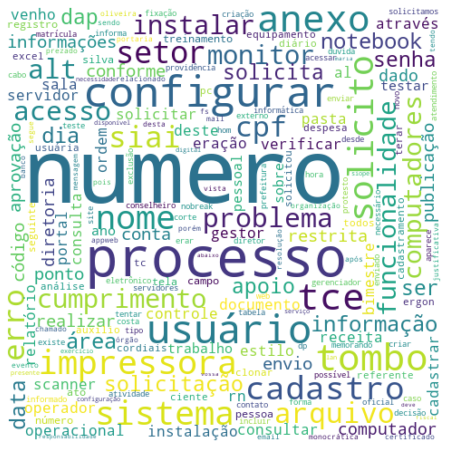

In [123]:
all_words = tokenizar(df['Descricao Atualizada'].values)

plt.figure(figsize=(10,8))
wordcloud = WordCloud(collocations=False, width=480, height=480, margin=0, 
                      background_color="white").generate(' '.join(all_words))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

- Stemming

In [124]:
nltk.download('rslp')
stemmer = nltk.stem.RSLPStemmer()

df['Descricao Atualizada'] = df['Descricao Atualizada'].apply(lambda x: ' '.join(stemmer.stem(term) for term in x.split()))
df.iloc[268]['Descricao Atualizada']

[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\gfeli\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


'identific err colun val realiz exercíci balanç orcamentari receit identific inclus val estranh vind arqu import seg arqu analis'

- Removendo acentuação

In [125]:
df['Descricao Atualizada'] = df['Descricao Atualizada'].apply(unidecode)
df.iloc[268]['Descricao Atualizada']

'identific err colun val realiz exercici balanc orcamentari receit identific inclus val estranh vind arqu import seg arqu analis'

### Criação de features

- Tokenizar palavras stemmizadas

In [126]:
todas_palavras = tokenizar(df['Descricao Atualizada'].values)
        
freq_palavras = nltk.FreqDist(todas_palavras)

print('Total de palavras: {}'.format(len(freq_palavras)))
print('Mais comuns: {}'.format(freq_palavras.most_common(5)))

Total de palavras: 2848
Mais comuns: [('numer', 2674), ('process', 598), ('solicit', 556), ('inform', 382), ('configur', 364)]


- Nuvem de palavras

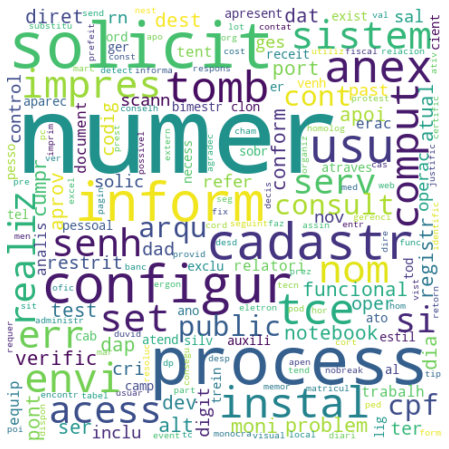

In [127]:
plt.figure(figsize=(10,8))
wordcloud = WordCloud(collocations=False, width=480, height=480, margin=0, 
                      background_color="white").generate(' '.join(todas_palavras))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

- Utilizando as 1000 palavras mais comuns

In [128]:
#numero de features
#features_palavras = list(freq_palavras.keys())[:1000]
features_palavras = list(dict(sorted(freq_palavras.items(), key=lambda c: c[1], reverse=True)).keys())[:1000]
print(features_palavras)

['numer', 'process', 'solicit', 'inform', 'configur', 'cadastr', 'usu', 'anex', 'tomb', 'tce', 'instal', 'comput', 'envi', 'set', 'nom', 'sistem', 'impres', 'acess', 'senh', 'err', 'realiz', 'n', 'si', 'serv', 'public', 'cpf', 'consult', 'arqu', 'cont', 'problem', 'alt', 'cumpr', 'moni', 'are', 'port', 'funcional', 'ser', 'dest', 'notebook', 'dev', 'dia', 'diret', 'dap', 'registr', 'verific', 'dat', 'atual', 'test', 'apoi', 'pont', 'aprov', 'conform', 'restrit', 'oper', 'codig', 'cri', 'ter', 'dad', 'operac', 'refer', 'past', 'sal', 'nov', 'ges', 'solic', 'rn', 'control', 'digit', 'scann', 'relatori', 'document', 'equip', 'analis', 'erac', 'tent', 'trabalh', 'apresent', 'al', 'pessoal', 'ord', 'atraves', 'estil', 'receit', 'necess', 'bimestr', 'lig', 'venh', 'auxili', 'aparec', 'sobr', 'exist', 'cab', 'ano', 'ger', 'tod', 'trein', 'silv', 'camp', 'atend', 'tel', 'inclu', 'ato', 'pesso', 'er', 'clon', 'cient', 'seguint', 'dire', 'decis', 'usuar', 'excel', 'cord', 'eletron', 'tc', 'pc', 

- Função para testar selecionar as principais palavras da descrição

In [129]:
def find_features(descricao):
    palavras_descricao = word_tokenize(descricao)
    features = {palavra:(palavra in palavras_descricao) for palavra in features_palavras}
    return features

In [130]:
df.loc[55,'Descricao Atualizada']

'coloq imprim frent vers quer econom papel agor alerd pisc imprim'

In [131]:
# Testando a função
features = find_features(df.loc[55,'Descricao Atualizada'])
for key, value in features.items():
    if value == True:
        print(key)

imprim
vers
quer
agor


- Aplicando a função criada sobre o dataset para criação das features

In [132]:
chamados = list(zip(df['Descricao Atualizada'], 
                    df['Classificação']))
chamados[204]

('acess relatori org situ entreg rre rgf dam prefeit bent trair ano numer aparec seguint mens cryst report activex design err numeroenumer failed to open rowset detail numer microsoft odbc sql serv driv sql serv subquery returned mor than numer valu thil is not permitted when the subquery follow or when the subquery is used an expression tce port arearestrit sistem rel orga relatori imprimirrptnov asp lin numer',
 1)

In [133]:
seed = 1
np.random.seed = seed
np.random.shuffle(chamados)

featuresets = [(find_features(texto), classe) for (texto, classe) in chamados]

In [134]:
dataset = np.array(featuresets)
dataset[0]

array([{'numer': True, 'process': False, 'solicit': False, 'inform': False, 'configur': False, 'cadastr': False, 'usu': False, 'anex': False, 'tomb': True, 'tce': False, 'instal': True, 'comput': False, 'envi': False, 'set': False, 'nom': False, 'sistem': False, 'impres': False, 'acess': False, 'senh': False, 'err': False, 'realiz': False, 'n': False, 'si': False, 'serv': False, 'public': False, 'cpf': False, 'consult': False, 'arqu': False, 'cont': False, 'problem': False, 'alt': False, 'cumpr': False, 'moni': False, 'are': False, 'port': False, 'funcional': False, 'ser': False, 'dest': False, 'notebook': True, 'dev': False, 'dia': False, 'diret': False, 'dap': False, 'registr': False, 'verific': False, 'dat': False, 'atual': False, 'test': False, 'apoi': False, 'pont': False, 'aprov': False, 'conform': False, 'restrit': False, 'oper': False, 'codig': False, 'cri': False, 'ter': False, 'dad': False, 'operac': False, 'refer': False, 'past': False, 'sal': True, 'nov': False, 'ges': Fals

### Criação dos datasets

- Separando os datasets de treino e teste

In [135]:
treino, teste = train_test_split(dataset, test_size = 0.3, random_state=seed, stratify=dataset[:,1])

print("Treino:", len(treino))
print("Teste:", len(teste))

Treino: 1827
Teste: 783


- Info do treino

In [136]:
df_treino = pd.DataFrame(treino, columns=['features', 'label'])
display(df_treino.info())
df_treino.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 2 columns):
features    1827 non-null object
label       1827 non-null object
dtypes: object(2)
memory usage: 28.7+ KB


None

,features,label
0,"{'numer': True, 'process': True, 'solicit': Fa...",1
1,"{'numer': False, 'process': False, 'solicit': ...",1
2,"{'numer': True, 'process': True, 'solicit': Fa...",1
3,"{'numer': False, 'process': False, 'solicit': ...",1
4,"{'numer': False, 'process': False, 'solicit': ...",1


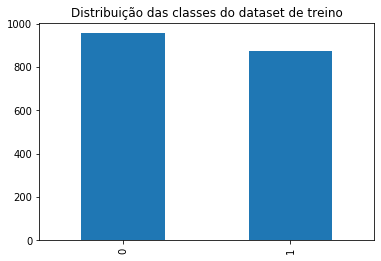

In [137]:
df_treino.label.value_counts().plot.bar()
plt.title('Distribuição das classes do dataset de treino')
plt.show()

- Info do teste

In [138]:
df_teste = pd.DataFrame(teste, columns=['features', 'label'])
display(df_teste.info())
df_teste.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783 entries, 0 to 782
Data columns (total 2 columns):
features    783 non-null object
label       783 non-null object
dtypes: object(2)
memory usage: 12.4+ KB


None

,features,label
0,"{'numer': False, 'process': False, 'solicit': ...",0
1,"{'numer': False, 'process': False, 'solicit': ...",0
2,"{'numer': False, 'process': True, 'solicit': T...",1
3,"{'numer': False, 'process': False, 'solicit': ...",0
4,"{'numer': False, 'process': False, 'solicit': ...",1


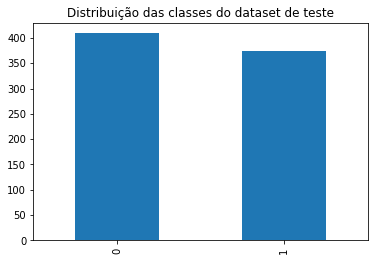

In [139]:
df_teste.label.value_counts().plot.bar()
plt.title('Distribuição das classes do dataset de teste')
plt.show()

# Modelo Classificação

### Imports

In [140]:
import seaborn as sns
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

### Modelos

In [141]:
# Definindo modelos
names = ["k-Nearest Neighbors", "Árvores de decisão", "Naive Bayes", "MultiLayer Perceptron (MLP)"]

classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    MultinomialNB(),
    MLPClassifier()
]

models = zip(names, classifiers)

for name, model in models:
    nltk_model = SklearnClassifier(model)
    nltk_model.train(treino)
    accuracy = nltk.classify.accuracy(nltk_model, teste)*100
    print("{} Accuracy: {}".format(name, accuracy))

k-Nearest Neighbors Accuracy: 84.16347381864622
Árvores de decisão Accuracy: 85.82375478927203
Naive Bayes Accuracy: 90.29374201787995
MultiLayer Perceptron (MLP) Accuracy: 88.25031928480205


In [142]:
# make class label prediction for testing set
txt_features, labels = zip(*teste)

### Metricas de validação para cada modelo utilizado

In [143]:
def metricas(labels, prediction):
    print('Accuracy score: ', accuracy_score(labels, prediction), '\n')
    print(classification_report(labels, prediction))
    matriz_confusao = pd.DataFrame(confusion_matrix(labels, prediction),
                                   index = [['Atual', 'Atual'], ['Equipamento', 'Sistema']],
                                   columns = [['Previsto', 'Previsto'], ['Equipamento', 'Sistema']])
    display(matriz_confusao)
    
    plt.figure(figsize=(10,8))
    sns.heatmap(confusion_matrix(labels, prediction), annot=True, cmap='Blues')
    plt.title('Matriz de confusão')
    plt.xlabel('Previsto')
    plt.ylabel('Atual')
    plt.show()

### k-Nearest Neighbors

In [144]:
nltk_knn = SklearnClassifier(KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, 
                                                 p=2, metric='minkowski', metric_params=None, n_jobs=None))
nltk_knn.train(treino)

<SklearnClassifier(KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform'))>

- Prevendo valores pro dataset de treino

In [145]:
prediction_knn = nltk_knn.classify_many(txt_features)

- Verificando metricas

Accuracy score:  0.8416347381864623 

              precision    recall  f1-score   support

           0       0.79      0.95      0.86       409
           1       0.93      0.72      0.81       374

    accuracy                           0.84       783
   macro avg       0.86      0.84      0.84       783
weighted avg       0.86      0.84      0.84       783



Previsto        
                  Equipamento Sistema
Atual Equipamento         389      20
      Sistema             104     270

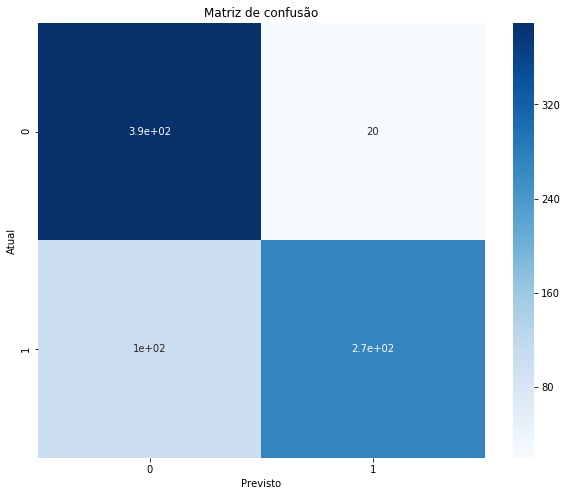

In [146]:
metricas(labels, prediction_knn)

### Árvores de decisão

In [147]:
nltk_tree = SklearnClassifier(DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, 
                                                      min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                                      max_features=None, random_state=None, max_leaf_nodes=None, 
                                                      min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None))
nltk_tree.train(treino)

<SklearnClassifier(DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'))>

- Prevendo valores pro dataset de treino

In [148]:
prediction_tree = nltk_tree.classify_many(txt_features)

- Verificando metricas

Accuracy score:  0.876117496807152 

              precision    recall  f1-score   support

           0       0.87      0.90      0.88       409
           1       0.88      0.85      0.87       374

    accuracy                           0.88       783
   macro avg       0.88      0.88      0.88       783
weighted avg       0.88      0.88      0.88       783



Previsto        
                  Equipamento Sistema
Atual Equipamento         367      42
      Sistema              55     319

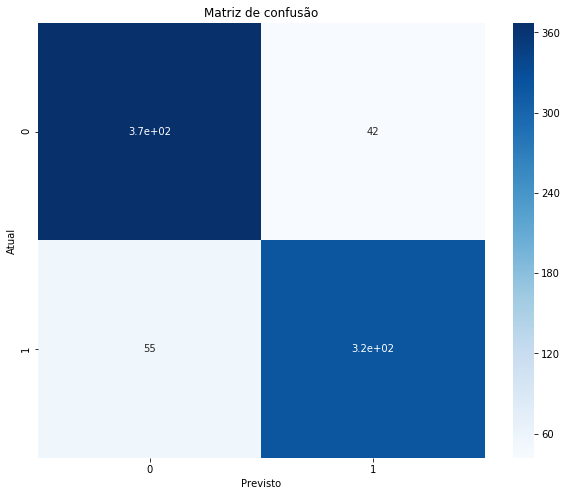

In [149]:
metricas(labels, prediction_tree)

### Naive Bayes

In [150]:
nltk_nb = SklearnClassifier(MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None))
nltk_nb.train(treino)

<SklearnClassifier(MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))>

- Prevendo valores pro dataset de treino

In [151]:
prediction_nb = nltk_nb.classify_many(txt_features)

- Verificando metricas

Accuracy score:  0.9029374201787995 

              precision    recall  f1-score   support

           0       0.89      0.92      0.91       409
           1       0.91      0.88      0.90       374

    accuracy                           0.90       783
   macro avg       0.90      0.90      0.90       783
weighted avg       0.90      0.90      0.90       783



Previsto        
                  Equipamento Sistema
Atual Equipamento         378      31
      Sistema              45     329

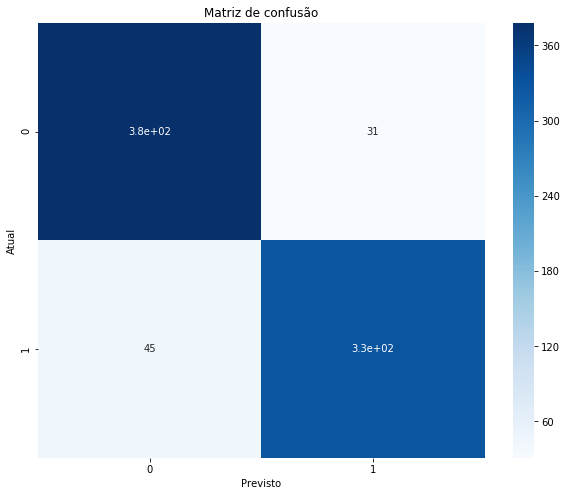

In [152]:
metricas(labels, prediction_nb)

### MultiLayer Perceptron (MLP)

In [153]:
nltk_mlp = SklearnClassifier(MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', solver='adam', 
                                           alpha=0.0001, batch_size='auto', learning_rate='constant', 
                                           learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, 
                                           random_state=None, tol=0.0001, verbose=False, warm_start=False, 
                                           momentum=0.9, nesterovs_momentum=True, early_stopping=False, 
                                           validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
                                           n_iter_no_change=10))
nltk_mlp.train(treino)

<SklearnClassifier(MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False))>

- Prevendo valores pro dataset de treino

In [154]:
prediction_mlp = nltk_mlp.classify_many(txt_features)

- Verificando metricas

Accuracy score:  0.8876117496807152 

              precision    recall  f1-score   support

           0       0.88      0.91      0.89       409
           1       0.90      0.87      0.88       374

    accuracy                           0.89       783
   macro avg       0.89      0.89      0.89       783
weighted avg       0.89      0.89      0.89       783



Previsto        
                  Equipamento Sistema
Atual Equipamento         371      38
      Sistema              50     324

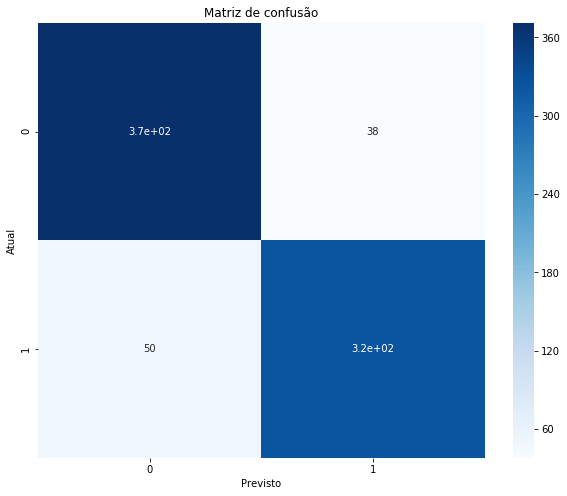

In [155]:
metricas(labels, prediction_mlp)